# Implementing a Neural Network from Scratch

--- 
## Introduction
In this post, we're going to implement a fully-connected neural network from scratch and use it to perform sentiment analysis on the IMDB movie reviews dataset. That is – we'll create a network to tell us if a movie review is positive or negative. The IMDB dataset is included with Keras, so let's dive right in. 

---
## Loading the Data

We load the data like usual. The `num_words=10000` says that we only want to keep that 10,000 most frequent words. 

In [1]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Using TensorFlow backend.


Currently the reviews are stored as integer sequences where each integer represents a given word. The following function can convert an integer sequence back into the original review. The `word_index` maps each word to its integer, and by reversing that index, we can map each integer to its word. The '?' represents a word that was not in the top 10,000 words, so we don't know what it is. 

In [2]:
def sequence_to_text(sequence):
    """Converts an integer sequence into the actual review text."""
    word_index = imdb.get_word_index()
    reverse_index = {value: key for (key, value) in word_index.items()}
    return ' '.join([reverse_index.get(i - 3, '?') for i in sequence])

print("Review")
print("~~~~~~")
print(sequence_to_text(train_data[0]), end="\n\n")

print("Sentiment")
print("~~~~~~~~~")
print(train_labels[0])

Review
~~~~~~
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done

We have to prepare our data to be fed into a neural network. We'll do this by creating a binary vector to represent each review. Each vector will be be `(10000,1)` and a 1 at index $i$ will indicate that word $i$ occurred in our review. One thng to not that this loses some valuable sequential information. For instance, the reviews "bad. not good." and "good. not bad." would have the same representation since they contain the same words. However, the first review describes a bad movie and the second review describes a good movie. There are other models that can handle sequential data like this, but this is an okay representation for now.

In [3]:
import numpy as np 

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

# Vectorize our input data 
vectorized_train_data = vectorize_sequences(train_data)
vectorized_test_data = vectorize_sequences(test_data)

# Vectorize our label data as well 
vectorized_train_labels = np.asarray(train_labels).astype('float32')
vectorized_test_labels = np.asarray(test_labels).astype('float32')

Just to make everything is in order, let's check the shape of our data. 

In [4]:
print('Input Data')
print('Train Data', vectorized_train_data.shape)
print('Test Data', vectorized_test_data.shape)

print('\nOutput Data')
print('Train Labels', vectorized_train_labels.shape)
print('Train Labels', vectorized_test_labels.shape)

Input Data
Train Data (25000, 10000)
Test Data (25000, 10000)

Output Data
Train Labels (25000,)
Train Labels (25000,)


Finally, we can create our train, validation, and test splits. `.T` transposes the datasets. Currently our datasets have the number of samples as the first axis. Because of how we are going to implement forward propagation, we will transpose our datasets to make the number of samples the final axis. 

In [9]:
# Separate input data
x_val = vectorized_train_data[:10000].T
x_train = vectorized_train_data[10000:].T
x_test = vectorized_test_data[:].T

# Separate labels 
y_val = vectorized_train_labels[:10000]
y_train = vectorized_train_labels[10000:]
y_test = vectorized_test_labels[:]

--- 
## Activation and Cost Functions 
Before implementing our network, we will define some activation and cost functions.

### Activation Functions
For our network, we actually only need sigmoid (for the final layer) and ReLU for the hidden layers. However, hyperbolic tangent and leaky ReLU have been provided as examples. A leaky ReLU is like a regular ReLU but with a non-zero derivative for $z < 0$. Note that each activation function has a method for forward propagation which computes $g(z)$ and a method for backward propagation which computes $dA g'(z)$.

In [8]:
class ActivationFunction:
    """An abstract class representing an activation function."""
    
    def __init__(self):
        pass 
    
    def forward(self, Z): 
        raise NotImplementedError
        
    def backward(self, dA, Z): 
        raise NotImplementedError
        

class Sigmoid(ActivationFunction): 
    """Implementation of the sigmoid activation function."""
    
    def forward(self, Z): 
        return 1.0 / (1.0 + np.exp(-Z))
        
    def backward(self, dA, Z): 
        s = 1 / (1+np.exp(-Z))
        dZ = dA * s * (1-s)
        return dZ
    

class Tanh(ActivationFunction): 
    """Implementation of the hypterbolic tangent activation function."""
    
    def forward(self, Z): 
        return np.tanh(Z)
        
    def backward(self, dA, Z): 
        t = tanh(Z)
        return dA * (1 - t*t)
    

class ReLU(ActivationFunction): 
    """Implementation of the ReLU function."""
    
    def forward(self, Z): 
        return np.maximum(Z, 0)
        
    def backward(self, dA, Z): 
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        return dZ
    

class LeakyReLU(ActivationFunction): 
    """Implementation of the Leaky ReLU function."""
    
    def __init__(self, alpha): 
        super().__init__()
        self.alpha = alpha
    
    def forward(self, Z): 
        return np.maximum(Z, self.alpha*Z)
        
    def backward(self, dA, Z): 
        dZ = np.ones_like(Z)
        dZ[Z <= 0] = self.alpha
        return dA*dZ

### Cost Functions
We can define the cost functions similar to how we defined the activation functions – with an abstract class and then subclasses for each cost function. Cross entropy and mean-squared error are implemented below, but additional options could be added. The `eps=1e-8` prevents NaN from propagating through our network in the case of dividing by zero. 

In [7]:
class CostFunction:
    """An abstract class representing a cost function."""
    
    def __init__(self):
        pass 
    
    def cost(self, AL, Y):
        raise NotImplementedError
        
    def derivative(self, AL, Y):
        raise NotImplementedError
    

class CrossEntropy(CostFunction):
    """Implementation of the Cross Entropy Cost Function."""
    
    def cost(self, AL, Y):
        m = Y.shape[-1]
        eps = 1e-8
        cost = (-1/m) * np.sum(np.multiply(np.log(AL + eps), Y) + np.multiply(np.log((1-AL) + eps),(1-Y)))
        return np.squeeze(cost)
    
    def derivative(self, AL, Y):
        eps = 1e-8
        return - (np.divide(Y, AL + eps) - np.divide(1 - Y, 1 - AL + eps))
    

class MeanSquaredError(CostFunction):
    """Implementation of the Mean Squared Error Cost Function"""
    
    def cost(self, AL, Y):
        m = Y.shape[-1]
        cost = (1/(2*m)) * np.sum(np.square(Y - AL))
        return np.squeeze(cost)
    
    def derivative(self, AL, Y):
        return AL - Y

## Implementing our Neural Network
Finally, we will implement the network. Because of the way defining classes works in Jupyter notebooks, the code will be explained first and then provided in a single cell. 

### Initialization 
To initialize our network we will simply provide a list of desire layer sizes. The network will then initialize the weights, biases, activation functions, and cost function for the network. We are using a Cross Entropy cost function since we are doing binary classification. 
```python
def __init__(self, layer_sizes):
    """Initializes a new network with the given dimensions."""
    self.num_layers = len(layer_sizes)
    self.layer_sizes = layer_sizes
    self.cost_function = CrossEntropy()
    self.activation_functions = self.initialize_activation_functions(layer_sizes)
    self.parameters = self.initialize_parameters(layer_sizes)
```

Next, we initialize the activation functions. Technically, this could be added as an initialization parameter, but for now we will keep things simple by just using ReLU for hidden layers and sigmoid for the output layer. Also, note that we start with `activations = [None]` since the input layer has no activation function. 
```python
def initialize_activation_functions(self, layer_sizes):
    """Returns an array of activation functions."""
    activations = [None]
    for _ in range(1, self.num_layers-1):
        activations.append(ReLU())
    activations.append(Sigmoid())
    return activations
```

Finally, we will store the weights and biases in a dictionary. We use random initialization for the weight matrices with a scaling factor of 0.01 to ensure that this performs ok (in the previous post we saw if the weights are too large learning will be slow.) 
```python 
def initialize_parameters(self, layer_sizes):
    """Returns a new dictionary of weights and biases."""
    parameters = {}
    for l in range(1, self.num_layers):
        parameters['W' + str(l)] = np.random.randn(layer_sizes[l], layer_sizes[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_sizes[l], 1))
    return parameters
```

### Forward Propagation 
We will split implementing forward propagation into two parts: (1) a single layer forward propagation, and (2) forward propagation for the whole network. A single layer is simple, we just compute $Z_l = W_l A_{l-1} + b_l$ and $A_l = g(Z_l)$. We return all of the values as a cache so they can be reused during backward propagation. 
```python 
def forward_propagation_step(self, W, A_prev, b, activation):
    """Compute the output of a single layer."""
    Z = np.dot(W, A_prev) + b
    A = activation.forward(Z)
    cache = (W, A_prev, b, Z, A)
    return A, cache
```

Then, we implement the forward propagation for the entire network. Note that we also do `caches = [None]` so that layer $l$ has cache $l$. 
```python
def forward_propagation(self, X):
    """Compute the output for the given examples."""
    A = X 
    caches = [None]

    for layer in range(1, self.num_layers):
        A_prev = A
        W = self.parameters['W' + str(layer)]
        b = self.parameters['b' + str(layer)]
        activation = self.activation_functions[layer]
        A, cache = self.forward_propagation_step(W, A_prev, b, activation)
        caches.append(cache)

    return A, caches
```

### Backpropagation
We also implement backpropagation in two parts. First, for a single layer. 
```python
def backward_propagation_step(self, dA, cache, activation):
    """Compute the gradients of a single layer."""
    (W, A_prev, b, Z, A) = cache
    m = A_prev.shape[1]
    dZ = activation.backward(dA, Z)
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db
```

Then for the entire network.
```python 
def backward_propagation(self, AL, Y, caches): 
    """Compute the gradients based on the results of forward propagation."""
    gradients = {}
    Y = Y.reshape(AL.shape)

    dA = self.cost_function.derivative(AL, Y)

    for layer in reversed(range(1,self.num_layers)):
        cache = caches[layer]
        activation = self.activation_functions[layer]
        dA, dW, db = self.backward_propagation_step(dA, cache, activation)
        gradients["dA" + str(layer-1)] = dA 
        gradients["dW" + str(layer)] = dW 
        gradients["db" + str(layer)] = db

    return gradients 
```

### Putting It All Together

In [5]:
class Network:
    
    #
    # Initialization
    #
    
    def __init__(self, layer_sizes):
        """Initializes a new network with the given dimensions."""
        self.num_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.cost_function = CrossEntropy()
        self.activation_functions = self.initialize_activation_functions(layer_sizes)
        self.parameters = self.initialize_parameters(layer_sizes) 
        
        
    def initialize_activation_functions(self, layer_sizes):
        """Returns an array of activation functions."""
        activations = [None]
        for _ in range(1, self.num_layers-1):
            activations.append(ReLU())
        activations.append(Sigmoid())
        return activations
            
        
    def initialize_parameters(self, layer_sizes):
        """Returns a new dictionary of weights and biases."""
        parameters = {}
        for l in range(1, self.num_layers):
            parameters['W' + str(l)] = np.random.randn(layer_sizes[l], layer_sizes[l-1]) * 0.01
            parameters['b' + str(l)] = np.zeros((layer_sizes[l], 1))
        return parameters
    
    
    #
    # Forward Propagation
    #
    
    def forward_propagation(self, X):
        """Compute the output for the given examples."""
        A = X 
        caches = [None]
        
        for layer in range(1, self.num_layers):
            A_prev = A
            W = self.parameters['W' + str(layer)]
            b = self.parameters['b' + str(layer)]
            activation = self.activation_functions[layer]
            A, cache = self.forward_propagation_step(W, A_prev, b, activation)
            caches.append(cache)
            
        return A, caches
    
    
    def forward_propagation_step(self, W, A_prev, b, activation):
        """Compute the output of a single layer."""
        Z = np.dot(W, A_prev) + b
        A = activation.forward(Z)
        cache = (W, A_prev, b, Z, A)
        return A, cache
    
    
    #
    # Backward Propagation 
    #
    
    def backward_propagation(self, AL, Y, caches): 
        """Compute the gradients based on the results of forward propagation."""
        gradients = {}
        Y = Y.reshape(AL.shape)
        
        dA = self.cost_function.derivative(AL, Y)
        
        for layer in reversed(range(1,self.num_layers)):
            cache = caches[layer]
            activation = self.activation_functions[layer]
            dA, dW, db = self.backward_propagation_step(dA, cache, activation)
            gradients["dA" + str(layer-1)] = dA 
            gradients["dW" + str(layer)] = dW 
            gradients["db" + str(layer)] = db
            
        return gradients 
    
    
    def backward_propagation_step(self, dA, cache, activation):
        """Compute the gradients of a single layer."""
        (W, A_prev, b, Z, A) = cache
        m = A_prev.shape[1]
        dZ = activation.backward(dA, Z)
        dW = (1/m) * np.dot(dZ, A_prev.T)
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        return dA_prev, dW, db
    
    
    #
    # Compute Cost 
    #
    
    def compute_cost(self, AL, Y):
        """Computes the overall cost using the network's cost function."""
        return self.cost_function.cost(AL, Y)

---
## Training the Neural Network
Next, we will write functionality for training our network. These are outside the `Network` class because the network should only be concerned with its weights, biases, and making predictions. First, we will implement the gradient descent update rule, then a generator for creating minibatches, then a function for network accuracy, and finally the training function. 

### Gradient Descent 
A single step of gradient descent will update network parameters based on the learning rate `eta`. 

In [13]:
def gradient_descent_update(network, gradients, eta):
    parameters = network.parameters
    for i in range(1, network.num_layers):
        parameters["W" + str(i)] = network.parameters["W" + str(i)] - eta * gradients["dW" + str(i)]
        parameters["b" + str(i)] = network.parameters["b" + str(i)] - eta * gradients["db" + str(i)]
    return parameters

### Minibatches 
If we try to put all the samples through our network at once we may run out of memory and our training will be slow. Instead, we implement a helper which will give us batches of the specified size. Each time this function is called the batches will be different due to the permutation in the first line.

In [12]:
def minibatches(X, Y, batch_size):
    """Generates shuffled mini batches up to the given batch size."""
    permutation = np.random.permutation(X.shape[1])
    for k in range(0, X.shape[1], batch_size):
        batch_columns = permutation[k:k+batch_size]
        X_mini = X[:,batch_columns]
        Y_mini = Y[batch_columns]
        yield (X_mini, Y_mini)

### Accuracy
To make our predictions, we take the outputs of the sigmoid unit and round them to either 0 or 1. Since the values of `predictions == Y` will be 0 (incorrect) or 1 (correct), we can just take the mean to get the accuracy. Also note that `forward_propagation` will return the cached layer information, which we can discard when making predictions. 

In [11]:
def predict(network, X):
    outputs, _ = network.forward_propagation(X)
    outputs[outputs <= 0.5] = 0
    outputs[outputs > 0.5] = 1
    return outputs 

def accuracy(network, X, Y):
    predictions = predict(network, X)
    return np.mean(predictions == Y)

### Training 
Finally, we can combine all of the above into the training function.

In [23]:
def train(network, X, Y, epochs, learning_rate, batch_size=128, validation_data=None):
    """Trains a neural network using standard gradient descent."""
    history = {'train_cost': [], 'val_cost': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(epochs):
        print("\nStarting Epoch", epoch+1)
        # Training Cost 
        train_cost = 0
        for (mini_X, mini_Y) in minibatches(X, Y, batch_size):
            AL, caches = network.forward_propagation(mini_X)
            gradients = network.backward_propagation(AL, mini_Y, caches)
            train_cost += network.compute_cost(AL, mini_Y)
            parameters = gradient_descent_update(network, gradients, learning_rate)
        history['train_cost'].append(train_cost)
        print("Training cost:", train_cost)
        
        # Validation Cost
        if validation_data:
            val_cost = 0
            (val_X, val_Y) = validation_data
            for (mini_val_X, mini_val_Y) in minibatches(val_X, val_Y, batch_size):
                AL, caches = network.forward_propagation(mini_val_X)
                val_cost += network.compute_cost(AL, mini_val_Y)
            history['val_cost'].append(val_cost)
            print("Validation cost:", val_cost)
        
        # Training Accuracy 
        train_acc = accuracy(network, X, Y)
        history['train_acc'].append(train_acc)
        print("Training accuracy:", train_acc)
        
        # Validation Accuracy
        if validation_data: 
            (val_X, val_Y) = validation_data
            val_acc = accuracy(network, val_X, val_Y)
            history['val_acc'].append(val_acc)
            print("Validation accuracy:", val_acc)
    
    return history 

---
## Creating and Training a Network
Now we can see if our code actually works 😬

In [24]:
network = Network([10000, 32, 32, 1])
history = train(network, x_train, y_train, 20, 0.3, validation_data=(x_val, y_val))


Starting Epoch 1
Training cost: 81.81311147972521
Validation cost: 54.76631178568013
Training accuracy: 0.5035333333333334
Validation accuracy: 0.4947

Starting Epoch 2
Training cost: 81.8058740446145
Validation cost: 54.766977184822515
Training accuracy: 0.5035333333333334
Validation accuracy: 0.4947

Starting Epoch 3
Training cost: 81.77784515378153
Validation cost: 54.757722686259505
Training accuracy: 0.49646666666666667
Validation accuracy: 0.5053

Starting Epoch 4
Training cost: 81.79477870307657
Validation cost: 54.79882531704647
Training accuracy: 0.5035333333333334
Validation accuracy: 0.4947

Starting Epoch 5
Training cost: 81.68425232397135
Validation cost: 54.39123148472668
Training accuracy: 0.497
Validation accuracy: 0.5061

Starting Epoch 6
Training cost: 68.92074282495307
Validation cost: 44.47402263971942
Training accuracy: 0.7146666666666667
Validation accuracy: 0.7122

Starting Epoch 7
Training cost: 46.598514332217476
Validation cost: 25.6335655450474
Training accu

Similar to before, we can create plots for our loss and accuracy. 

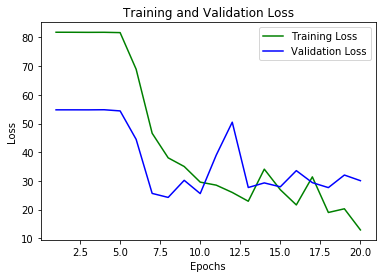

In [25]:
import matplotlib.pyplot as plt

train_loss = history['train_cost']
val_loss = history['val_cost']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

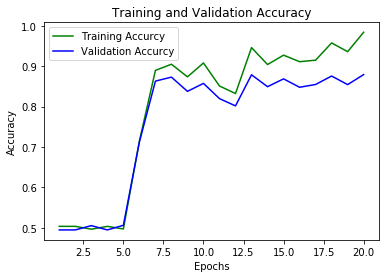

In [26]:
train_acc = history['train_acc']
val_acc = history['val_acc']
epochs = range(1, len(train_acc) + 1)

plt.clf() 
plt.plot(epochs, train_acc, 'g', label='Training Accurcy')
plt.plot(epochs, val_acc, 'b', label='Validation Accurcy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Finally, we can see that we are getting 98% training accuracy and 88% validation accuracy. There is clearly some overfitting, but our model is doing a pretty decent job

In [27]:
print("Training Accuracy", accuracy(network, x_train, y_train))
print("Validation Accuracy", accuracy(network, x_val, y_val))

Training Accuracy 0.9838666666666667
Validation Accuracy 0.8791


---
## Interesting Observations
As a final, interesting thing, let's take a look at a review our model incorrectly classified. The following helper function will return the indices of all the wrong predictions in our validation set. Since the validation set is the first 10,000 samples from the training data, we can use these indices to select the reviews from the original data and convert them to their text form.

In [53]:
def wrong_predictions(network, X, Y, orig_X, orig_Y):
    """Return reviews that were incorrectly predicted."""
    predictions = predict(network, X)
    wrong_indices = np.where(predictions != Y)[1]
    return (orig_X[wrong_indices], orig_Y[wrong_indices])

wrong_X, wrong_Y = wrong_predictions(network, x_val, y_val, train_data, train_labels)

Now, let's take a look at our first misclassified review.

In [56]:
print("Review")
print("~~~~~~")
print(sequence_to_text(wrong_X[0]), end="\n\n")

print("Sentiment")
print("~~~~~~~~~")
print(wrong_Y[0], end="\n\n")

print("Prediction")
print("~~~~~~~~~")
print(int(predict(network, vectorize_sequences([wrong_X[0]]).T)[0][0]))

Review
~~~~~~
? i hate reading reviews that say something like ? waste your time this film stinks on ice ' it does to that reviewer yet for me it may have some sort of ? charm if you like the other ? series films this one will be watchable if you like 40s ? films this one will be watchable br br this film is not as good in my opinion as any of the earlier series entries which starred richard ? as the protagonist it's much slower and the plot is trite you've seen this same narrative device used in many other films and usually better br br but the acting is good and so is the lighting and the dialog it's just lacking in energy and you'll likely figure out exactly what's going on and how it's all going to come out in the end not more than a quarter of the way through br br the ? series is semi noir and there character mood lighting camera movement and angles are more important than the story itself but this film is not noir it's too light weight and hollywood innocent for that neither ric

Pretty intersting right? This is a positi